# 千葉県内の自転車盗難者数について

## 自転車盗難件数をまとめる
地図に盗難の多い地域（300件以上（赤））とそれほどでもない地域（300件未満（青））を色づけして可視化


In [23]:
!pip install folium
!pip install geopy



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
import time
import os

df = pd.read_csv("jitensha.csv", encoding="utf-8", low_memory=False)

city_col = None
for col in df.columns:
    if "市区町村" in col or "市町村" in col or "区" in col or "住所" in col:
        city_col = col
        break

if city_col is None:
    raise ValueError("市区町村を示す列が見つかりません。列名を確認してください。")

df[city_col] = df[city_col].astype(str).str.strip()

df_city = df.groupby(city_col).size().reset_index(name="count")

geolocator = Nominatim(user_agent="chiba_bicycle_map")
latitudes = []
longitudes = []

for city in df_city[city_col]:
    try:
        loc = geolocator.geocode("千葉県 " + city)
        if loc:
            latitudes.append(loc.latitude)
            longitudes.append(loc.longitude)
        else:
            latitudes.append(None)
            longitudes.append(None)
    except:
        latitudes.append(None)
        longitudes.append(None)
    time.sleep(1)  

df_city["lat"] = latitudes
df_city["lon"] = longitudes

df_city_valid = df_city.dropna(subset=["lat", "lon"])

center_lat = df_city_valid["lat"].mean()
center_lon = df_city_valid["lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

for _, row in df_city_valid.iterrows():
    color = "red" if row["count"] >= 300 else "blue"

    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{row[city_col]}: {row['count']}件"
    ).add_to(m)

m.save("chiba_bicycle_theft_map.html")

m


## どの地域で盗難が多いか
地図から千葉の中でも北西寄りの（東京に近い）地域での盗難が相次いでいると分かった。また、盗難が少ない地域でもそれなりに差があり、東京湾に面している地域や近い地域などで盗難が3桁くらいの件数あっており、それら以外の地域では一桁や二桁の件数しか盗難が起こっていないと分かった。

### 被害者の特徴や月、時間別のグラフ

In [28]:
# 最初に一度だけ実行（順に実行するNotebook用）
!pip install pandas matplotlib folium geopy chardet scipy


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------------------------- ---------- 6.0/8.1 MB 30.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 28.5 MB/s  0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ------ --------------------------------- 6.3/38.5 MB 30.8 MB/s eta 0:00:02
   ----------- ---------------------------- 11.0/38.5 MB 27.0 MB/s eta 0:00:02
   ------------------ --------------------- 17.6/38.5 MB 29.3 MB/s eta 0:00:01
   ------------------------- -------------- 24.9/38.5 MB 29.7 MB/s eta 0:00:01
   -------------------------------- ------- 31.5/38.5 MB 30.1 MB/s eta 0:00:01
   ---------------------------------------  38.3/38.5 MB 30.5 MB/s eta 0:00:01
   ---------------------------------------- 38.5/38.5 MB 28.0 MB/s  0:00:01
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 27.5 MB/s  0:00:00
   ---------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


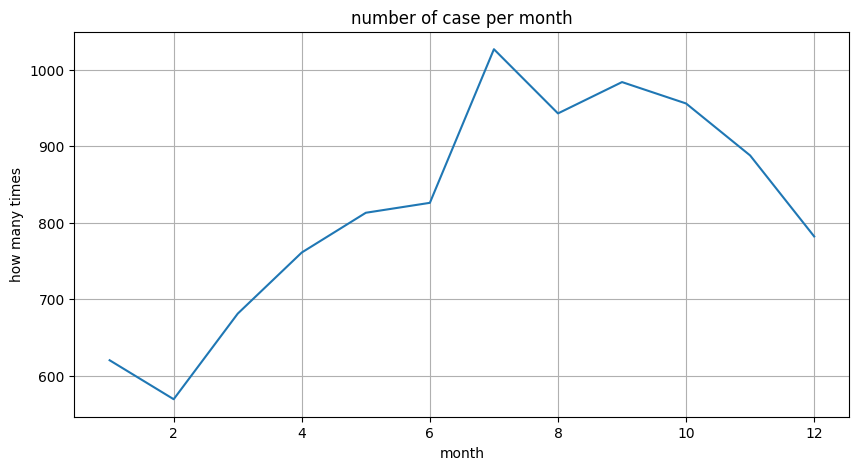

最も件数が多い月： 7.0 月


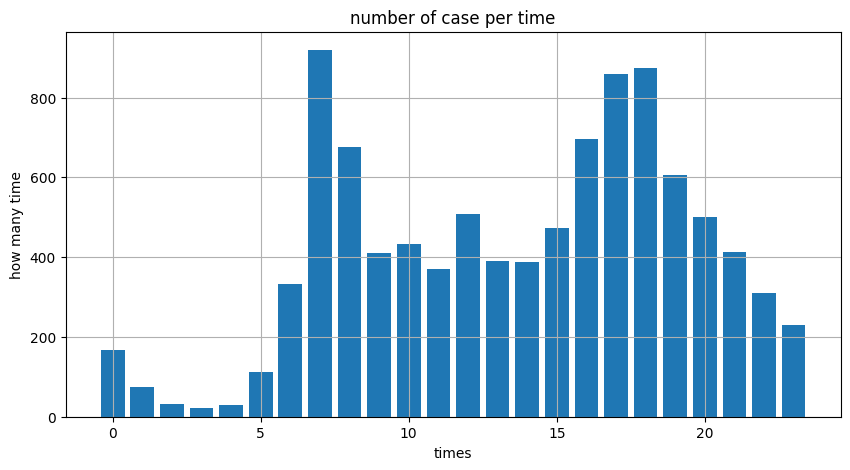

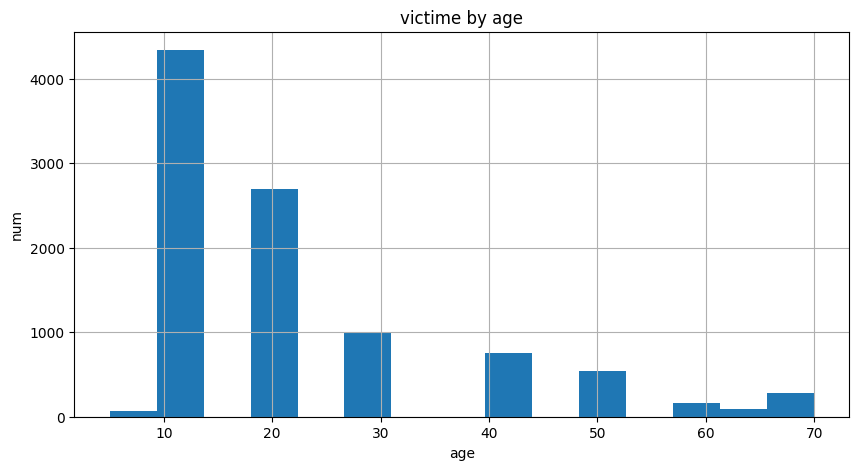

C:\Users\yuto2\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26045 (\N{CJK UNIFIED IDEOGRAPH-65BD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yuto2\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37664 (\N{CJK UNIFIED IDEOGRAPH-9320}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yuto2\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12379 (\N{HIRAGANA LETTER SE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yuto2\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12378 (\N{HIRAGANA LETTER ZU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\yuto2\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarnin

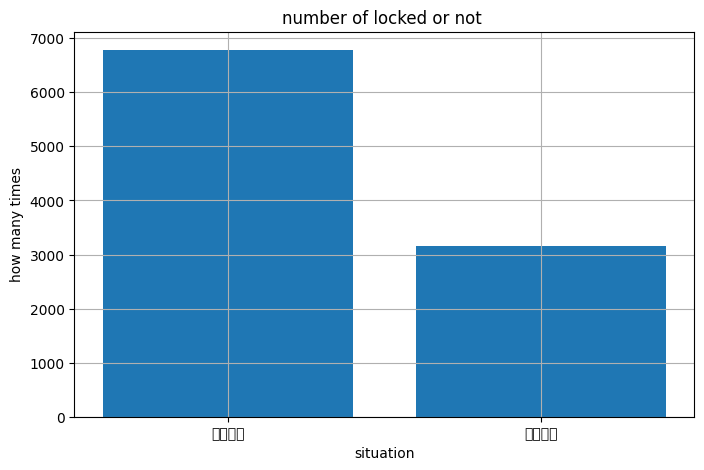

施錠関係
施錠せず    6781
施錠した    3162
Name: count, dtype: int64


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import time
# 発生年月日の前処理
df["発生年月日（始期）"] = pd.to_datetime(df["発生年月日（始期）"], errors="coerce")

df["month"] = df["発生年月日（始期）"].dt.month

monthly = df.groupby("month").size()

plt.figure(figsize=(10,5))
plt.plot(monthly.index, monthly.values)
plt.title("number of case per month")
plt.xlabel("month")
plt.ylabel("how many times")
plt.grid(True)
plt.show()

print("最も件数が多い月：", monthly.idxmax(), "月")

# "発生時（始期）" → "10時" "18時" などを想定
df["hour"] = df["発生時（始期）"].astype(str).str.extract(r"(\d+)").astype(float)

hourly = df.groupby("hour").size()

plt.figure(figsize=(10,5))
plt.bar(hourly.index, hourly.values)
plt.title("number of case per time")
plt.xlabel("times")
plt.ylabel("how many time")
plt.grid(True)
plt.show()

age_raw = df["被害者の年齢"].astype(str)


age_num = age_raw.str.extract(r"(\d+)")

age_num = age_num.astype(float)

age_num[age_raw.str.contains("未満", na=False)] = 5

age_num[age_raw.str.contains("高齢", na=False)] = 70

plt.figure(figsize=(10,5))
plt.hist(age_num.dropna(), bins=15)
plt.title("victime by age")
plt.xlabel("age")
plt.ylabel("num")
plt.grid(True)
plt.show()


lock_count = df["施錠関係"].value_counts()

plt.figure(figsize=(8,5))
plt.bar(lock_count.index, lock_count.values)
plt.title("number of locked or not ")
plt.xlabel("situation")
plt.ylabel("how many times")
plt.grid(True)
plt.show()

print(lock_count)


# 分析
### どの月が最も多いか
number of case per monthに盗難の件数をグラフにまとめたのでそれを見てみると7月が盗難の件数が一番多いことがわかる。また、グラフからどの月も平均的に盗難が起こっているのではなく月によってまばらに盗難が起こっているということがわかる。
### どの時間帯に多いか
number of case per timeから朝の7時の時間帯が一番盗難が行われており、その次に18時、17時と盗難が相次いでいることが分かった。なんで通勤通学、帰宅で人が多い時間帯に盗難が相次いでいるのか自分は理解できない。人手の少ない夜であったり早朝の時間のほうが件数が多いと思っていたため、この結果は不思議に思う。
### 被害者の特徴
圧倒的に10代の人々の自転車が盗難にあっている数が多くなっている。
### 鍵の有無によって盗難件数は変わるのか
今回のデータでは、施錠の有無で自転車盗難件数に明確な差が見られた。無施錠の自転車は施錠されている自転車に比べて盗難件数が大幅に多く、その差はおよそ2倍前後となっているため、施錠の有無によって件数は変わるといえるだろう。ただし、施錠ありでも一定数の被害が発生していることから、施錠が簡単なもの（ワイヤー錠のみなどの）取り外しやすい簡易な施錠にしているものが盗まれているのではないかと考える。なので、ダブルロックをするなり、人目の多い場所に止めるなどといったことを行うことで防犯対策ができるのではと考える。

# まとめ
データ上、無施錠の被害割合は高く、施錠の有無は盗難と強く関連していることが分かった。特に深夜時間帯や若年層において盗難が多いことから無施錠割合が高くなり、盗難が起こっているのではないかと考える。また、これらの時間帯や年代で自転車を利用している人に施錠の促進をすることでこのような盗難の件数を減少することができると思う。
